Самостоятельно написать код, реализующий искусственный нейрон с сигма-функцией активации, и возможность строить на его основе многослойные сети. Код должен также реализовывать градиентный спуск и обратное распространение ошибки.
На основе вашего кода:
1.	Решить задачу  классификации датаcета Iris одним нейроном.
2.	Решить задачу  классификации датаcета Iris одним  нейросетью из 2 слоев по 10 нейронов в слое.
3.	Отрисовать разделяющую линию для обеих моделей. Сравнить метрики классификации.

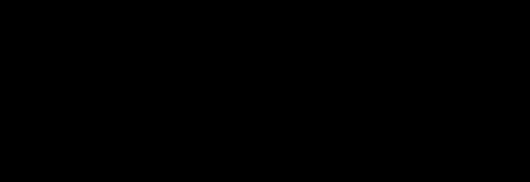

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

np.random.seed(42)
plt.rcParams["figure.figsize"] = (8, 6)


## Реализация “с нуля”: нейрон, слои, backprop, GD

Ниже **полностью своя реализация**:
- сигмоида и её производная;
- бинарная кросс-энтропия;
- слой `Dense`;
- слой активации `Sigmoid`;
- контейнер `Sequential`;
- обучение mini-batch градиентным спуском + обратное распространение ошибки.


In [10]:
# --- Активаторы и функции потерь ---
def sigmoid(x):
    x = np.clip(x, -50, 50)
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_grad(sigmoid_output):
    return sigmoid_output * (1.0 - sigmoid_output)

def bce_loss(y_true, y_pred, eps=1e-9):
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def bce_grad(y_true, y_pred, eps=1e-9):
    # dL/dy_pred для BCE (в среднем по батчу)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return (y_pred - y_true) / (y_pred * (1 - y_pred)) / y_true.shape[0]


# --- Слои ---
class Dense:
    def __init__(self, in_features, out_features):
        limit = np.sqrt(6 / (in_features + out_features))  # Xavier
        self.W = np.random.uniform(-limit, limit, (in_features, out_features))
        self.b = np.zeros((1, out_features))
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        return x @ self.W + self.b

    def backward(self, grad_out):
        self.dW = self.x.T @ grad_out
        self.db = np.sum(grad_out, axis=0, keepdims=True)
        return grad_out @ self.W.T

    def step(self, lr):
        self.W -= lr * self.dW
        self.b -= lr * self.db


class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        self.out = sigmoid(x)
        return self.out

    def backward(self, grad_out):
        return grad_out * sigmoid_grad(self.out)

    def step(self, lr):
        pass


class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad

    def step(self, lr):
        for layer in self.layers:
            layer.step(lr)

    def predict_proba(self, x):
        return self.forward(x)

    def predict(self, x, thr=0.5):
        return (self.predict_proba(x) >= thr).astype(int)


def train(model, X_train, y_train, epochs=2000, lr=0.1, batch_size=16, verbose_every=250):
    n = X_train.shape[0]
    for epoch in range(1, epochs + 1):
        idx = np.random.permutation(n)
        Xs = X_train[idx]
        ys = y_train[idx]

        for start in range(0, n, batch_size):
            xb = Xs[start:start+batch_size]
            yb = ys[start:start+batch_size]

            y_pred = model.forward(xb)
            grad = bce_grad(yb, y_pred)     # dL/dy_pred
            model.backward(grad)            # backprop
            model.step(lr)                  # GD

        if epoch % verbose_every == 0 or epoch == 1:
            loss = bce_loss(y_train, model.predict_proba(X_train))
            print(f"Epoch {epoch:4d} | loss={loss:.6f}")


## 2) Подготовка Iris: 2D-признаки + бинарная цель

Чтобы отрисовать разделяющую линию/границу, берём 2 признака:
- `petal length (cm)`
- `petal width (cm)`

Цель: **Setosa (1) vs остальные (0)**.


In [11]:
iris = load_iris()
X = iris.data[:, [2, 3]]  # 2D для визуализации
y_multi = iris.target
y = (y_multi == 0).astype(int).reshape(-1, 1)

# Нормализация
X_mean = X.mean(axis=0, keepdims=True)
X_std = X.std(axis=0, keepdims=True) + 1e-9
Xn = (X - X_mean) / X_std

X_train, X_test, y_train, y_test = train_test_split(
    Xn, y, test_size=0.25, random_state=42, stratify=y
)
X_train.shape, X_test.shape


((112, 2), (38, 2))

## 3) Модель №1: один нейрон (логистическая регрессия)

Архитектура: `Dense(2→1) + Sigmoid`.


In [12]:
one_neuron = Sequential([Dense(2, 1), Sigmoid()])
train(one_neuron, X_train, y_train, epochs=2000, lr=0.1, batch_size=16, verbose_every=250)

y_pred_1 = one_neuron.predict(X_test)
print("=== One neuron ===")
print("Accuracy :", accuracy_score(y_test, y_pred_1))
print("Precision:", precision_score(y_test, y_pred_1))
print("Recall   :", recall_score(y_test, y_pred_1))
print("F1       :", f1_score(y_test, y_pred_1))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_1))


Epoch    1 | loss=0.735632
Epoch  250 | loss=0.015493
Epoch  500 | loss=0.008942
Epoch  750 | loss=0.006421
Epoch 1000 | loss=0.005053
Epoch 1250 | loss=0.004186
Epoch 1500 | loss=0.003583
Epoch 1750 | loss=0.003139
Epoch 2000 | loss=0.002797
=== One neuron ===
Accuracy : 1.0
Precision: 1.0
Recall   : 1.0
F1       : 1.0
Confusion matrix:
 [[25  0]
 [ 0 13]]


## MLP (2 скрытых слоя по 10 нейронов)

Архитектура: `2→10→10→1` с сигмоидами.

Отрисовка разделяющей линии/границы (p = 0.5)
Для одного нейрона это прямая (линейная граница);
Для MLP —, как правило, нелинейная граница, рисуем контуром уровня 0.5.


In [13]:
mlp = Sequential([
    Dense(2, 10), Sigmoid(),
    Dense(10, 10), Sigmoid(),
    Dense(10, 1), Sigmoid()
])

train(mlp, X_train, y_train, epochs=4000, lr=0.05, batch_size=16, verbose_every=400)

y_pred_2 = mlp.predict(X_test)
print("=== MLP 10-10 ===")
print("Accuracy :", accuracy_score(y_test, y_pred_2))
print("Precision:", precision_score(y_test, y_pred_2))
print("Recall   :", recall_score(y_test, y_pred_2))
print("F1       :", f1_score(y_test, y_pred_2))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_2))

Epoch    1 | loss=0.648367
Epoch  400 | loss=0.013591
Epoch  800 | loss=0.004615
Epoch 1200 | loss=0.002605
Epoch 1600 | loss=0.001771
Epoch 2000 | loss=0.001325
Epoch 2400 | loss=0.001051
Epoch 2800 | loss=0.000867
Epoch 3200 | loss=0.000735
Epoch 3600 | loss=0.000637
Epoch 4000 | loss=0.000560
=== MLP 10-10 ===
Accuracy : 1.0
Precision: 1.0
Recall   : 1.0
F1       : 1.0
Confusion matrix:
 [[25  0]
 [ 0 13]]


Отрисовка разделяющей линии/границы (p = 0.5)

- Для одного нейрона это прямая (линейная граница);
- Для MLP —, как правило, нелинейная граница, рисуем контуром уровня 0.5.


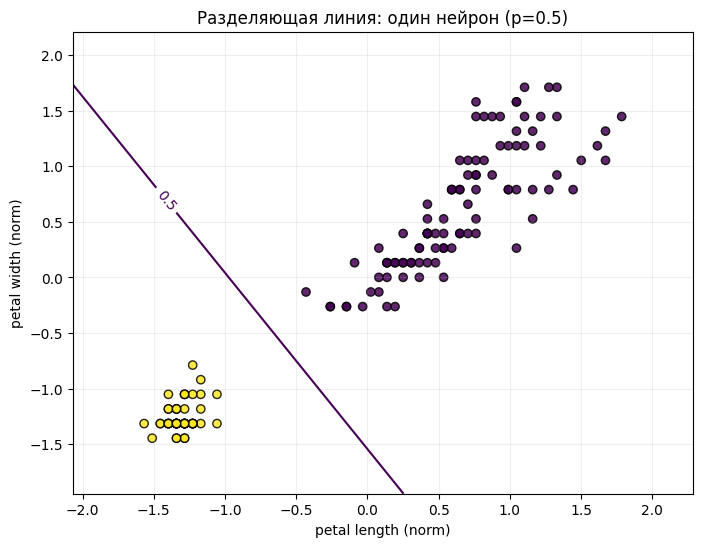

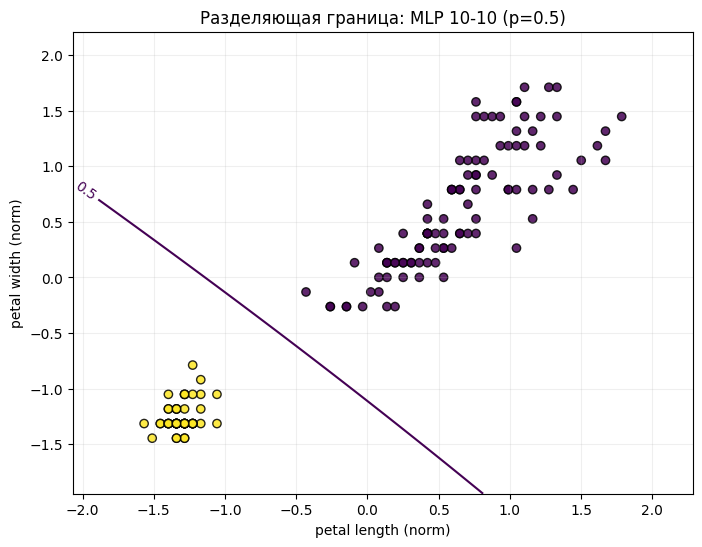

In [14]:
def plot_decision_boundary(model, Xn, y, title):
    x_min, x_max = Xn[:, 0].min() - 0.5, Xn[:, 0].max() + 0.5
    y_min, y_max = Xn[:, 1].min() - 0.5, Xn[:, 1].max() + 0.5

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = model.predict_proba(grid).reshape(xx.shape)

    plt.figure(figsize=(8,6))
    plt.scatter(Xn[:,0], Xn[:,1], c=y.ravel(), edgecolor="k", alpha=0.85)
    cs = plt.contour(xx, yy, probs, levels=[0.5])
    plt.clabel(cs, inline=1, fontsize=10)
    plt.title(title)
    plt.xlabel("petal length (norm)")
    plt.ylabel("petal width (norm)")
    plt.grid(alpha=0.2)
    plt.show()

plot_decision_boundary(one_neuron, Xn, y, "Разделяющая линия: один нейрон (p=0.5)")
plot_decision_boundary(mlp, Xn, y, "Разделяющая граница: MLP 10-10 (p=0.5)")


### Заключение по разделяющей линии и границе

Визуализация разделяющих поверхностей показала принципиальное различие между моделями. Для модели одного нейрона разделяющая граница представляет собой прямую линию, что соответствует линейной природе логистической регрессии.

Для многослойной нейронной сети была построена разделяющая граница уровня p = 0.5, которая в общем случае может иметь нелинейную форму. Однако в данной задаче граница, полученная MLP, практически совпадает с линейной, что дополнительно подтверждает линейную разделимость данных.

Таким образом, визуализация наглядно демонстрирует, что при простой структуре данных использование более сложной модели не даёт существенных преимуществ.


## Сравнение метрик

Сравнение метрик классификации на тестовой выборке.


In [15]:
def metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
    }

m1 = metrics(y_test, y_pred_1)
m2 = metrics(y_test, y_pred_2)

print("One neuron:", m1)
print("MLP 10-10 :", m2)


One neuron: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
MLP 10-10 : {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}


### Заключение по сравнению метрик

Сравнение метрик классификации для обеих моделей показало, что один нейрон и многослойная нейронная сеть демонстрируют одинаково высокое качество классификации на тестовой выборке. Все основные метрики (accuracy, precision, recall и F1-мера) имеют значение 1.0.

Полученный результат подтверждает, что для линейно разделимых данных увеличение сложности модели не приводит к улучшению качества классификации. В то же время многослойная нейронная сеть обладает большей выразительной способностью и может быть более эффективной для задач с более сложной, нелинейной структурой данных.
